In [1]:
import os
import requests
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
tf.__version__

'2.0.0'

In [2]:
attack_types, *features = requests.get('http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names').text.split('\n')[:-1]
attack_types = attack_types.split(',')
attack_types[-1] = attack_types[-1][:-1]
features_types_dict = {f.split(':')[0]: f.split(':')[1][1:-1] for f in features}
features = list(features_types_dict.keys())
features_types_dict['dst_host_srv_rerror_rate'] = 'continuous'
features_types_dict

{'duration': 'continuous',
 'protocol_type': 'symbolic',
 'service': 'symbolic',
 'flag': 'symbolic',
 'src_bytes': 'continuous',
 'dst_bytes': 'continuous',
 'land': 'symbolic',
 'wrong_fragment': 'continuous',
 'urgent': 'continuous',
 'hot': 'continuous',
 'num_failed_logins': 'continuous',
 'logged_in': 'symbolic',
 'num_compromised': 'continuous',
 'root_shell': 'continuous',
 'su_attempted': 'continuous',
 'num_root': 'continuous',
 'num_file_creations': 'continuous',
 'num_shells': 'continuous',
 'num_access_files': 'continuous',
 'num_outbound_cmds': 'continuous',
 'is_host_login': 'symbolic',
 'is_guest_login': 'symbolic',
 'count': 'continuous',
 'srv_count': 'continuous',
 'serror_rate': 'continuous',
 'srv_serror_rate': 'continuous',
 'rerror_rate': 'continuous',
 'srv_rerror_rate': 'continuous',
 'same_srv_rate': 'continuous',
 'diff_srv_rate': 'continuous',
 'srv_diff_host_rate': 'continuous',
 'dst_host_count': 'continuous',
 'dst_host_srv_count': 'continuous',
 'dst_hos

In [3]:
buf = requests.get('http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types').text
buf = buf.split('\n')[:-2]
target_classes = {
    'normal': 0,
    'u2r': 1,
    'r2l': 2,
    'probe': 3,
    'dos': 4
}
attack_types_dict = {line.split()[0]: line.split()[1] for line in buf}
attack_types_dict['normal'] = 'normal'
attack_types_dict

{'back': 'dos',
 'buffer_overflow': 'u2r',
 'ftp_write': 'r2l',
 'guess_passwd': 'r2l',
 'imap': 'r2l',
 'ipsweep': 'probe',
 'land': 'dos',
 'loadmodule': 'u2r',
 'multihop': 'r2l',
 'neptune': 'dos',
 'nmap': 'probe',
 'perl': 'u2r',
 'phf': 'r2l',
 'pod': 'dos',
 'portsweep': 'probe',
 'rootkit': 'u2r',
 'satan': 'probe',
 'smurf': 'dos',
 'spy': 'r2l',
 'teardrop': 'dos',
 'warezclient': 'r2l',
 'warezmaster': 'r2l',
 'normal': 'normal'}

In [4]:
# Получаем данные
_URL = 'http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz'
zip_file = tf.keras.utils.get_file(origin=_URL, fname="kddcup.data.gz")
base_dir = os.path.join(os.path.dirname(zip_file), 'kddcup.data')

In [5]:
import gzip
import shutil

with gzip.open(zip_file, 'rb') as f_in:
    with open(base_dir, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [6]:
# Считываем данные
df = pd.read_csv(base_dir, header=None)
df[41] = [i[:-1] for i in df[41].values]
df

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,normal
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.0,normal
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.00,0.0,0.00,0.0,0.0,normal
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.00,0.0,0.00,0.0,0.0,normal
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.00,0.0,0.00,0.0,0.0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898426,0,tcp,http,SF,212,2288,0,0,0,0,...,255,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0,normal
4898427,0,tcp,http,SF,219,236,0,0,0,0,...,255,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0,normal
4898428,0,tcp,http,SF,218,3610,0,0,0,0,...,255,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0,normal
4898429,0,tcp,http,SF,219,1234,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0,normal


In [7]:
# Получаем все виды атак с количеством примеров

df[41].value_counts()

smurf              2807886
neptune            1072017
normal              972781
satan                15892
ipsweep              12481
portsweep            10413
nmap                  2316
back                  2203
warezclient           1020
teardrop               979
pod                    264
guess_passwd            53
buffer_overflow         30
land                    21
warezmaster             20
imap                    12
rootkit                 10
loadmodule               9
ftp_write                8
multihop                 7
phf                      4
perl                     3
spy                      2
Name: 41, dtype: int64

In [8]:
# Выделяем 3 класса

NUM = 15000

df_smurf = df[df[41]=='smurf'][:NUM]
df_normal = df[df[41]=='normal'][:NUM]
df_satan = df[df[41]=='satan'][:NUM]

In [9]:
# Оставляем в данных только 3 класса - формируем новый датафрейм

df = df_smurf
df = df.merge(df_normal, how='outer')
df = df.merge(df_satan, how='outer')
len(df)

45000

In [10]:
# Убираем лишние (пока что) признаки

for i in range(7, 41):
    df.drop(i, axis=1, inplace=True)

In [11]:
# Смотрим статистику по оставшимся

for i in range(7):
    print(df[i].value_counts(), end='\n\n')

0        44396
1          245
3           59
27          35
20          19
         ...  
89           1
217          1
13724        1
91           1
12026        1
Name: 0, Length: 92, dtype: int64

tcp     28314
icmp    15157
udp      1529
Name: 1, dtype: int64

ecr_i        15107
http         13300
other        12097
private       2624
smtp           910
             ...  
http_2784        1
nnsp             1
IRC              1
http_443         1
ldap             1
Name: 2, Length: 65, dtype: int64

SF      31306
REJ     11969
S0       1699
S1         11
RSTO        6
S2          5
S3          2
RSTR        1
OTH         1
Name: 3, dtype: int64

1032    15000
0       13675
1        1171
216       240
213       183
        ...  
3724        1
1549        1
5519        1
1357        1
1707        1
Name: 4, Length: 1014, dtype: int64

0       30161
280        81
48         80
1263       77
891        75
        ...  
145         1
4179        1
7243        1
81          1
2047       

In [12]:
# В данном признаки только 3 существенных класса - оставляем только их

df[2].value_counts()

ecr_i        15107
http         13300
other        12097
private       2624
smtp           910
             ...  
http_2784        1
nnsp             1
IRC              1
http_443         1
ldap             1
Name: 2, Length: 65, dtype: int64

In [13]:
buf = df
df = buf[buf[2] == 'ecr_i']
df = df.merge(buf[buf[2] == 'http'], how='outer')
df = df.merge(buf[buf[2] == 'other'], how='outer')
len(df)

40504

In [14]:
# В данном признаки только 3 существенных класса - оставляем только их

df[3].value_counts()

SF     28650
REJ    10323
S0      1516
S1         8
S2         5
S3         1
OTH        1
Name: 3, dtype: int64

In [15]:
buf = df
df = buf[buf[3] == 'SF']
df = df.merge(buf[buf[3] == 'REJ'], how='outer')
df = df.merge(buf[buf[3] == 'S0'], how='outer')
len(df)

40489

In [16]:
df[0].value_counts()

0       40437
3           7
1           2
2           2
29          2
66          2
58          2
26          2
79          2
22          2
70          1
43          1
202         1
7           1
102         1
67          1
6           1
133         1
44          1
34          1
96          1
12          1
159         1
1484        1
78          1
414         1
16          1
48          1
81          1
310         1
120         1
89          1
155         1
60          1
316         1
189         1
30          1
62          1
110         1
Name: 0, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7582565990>,
      dtype=object)

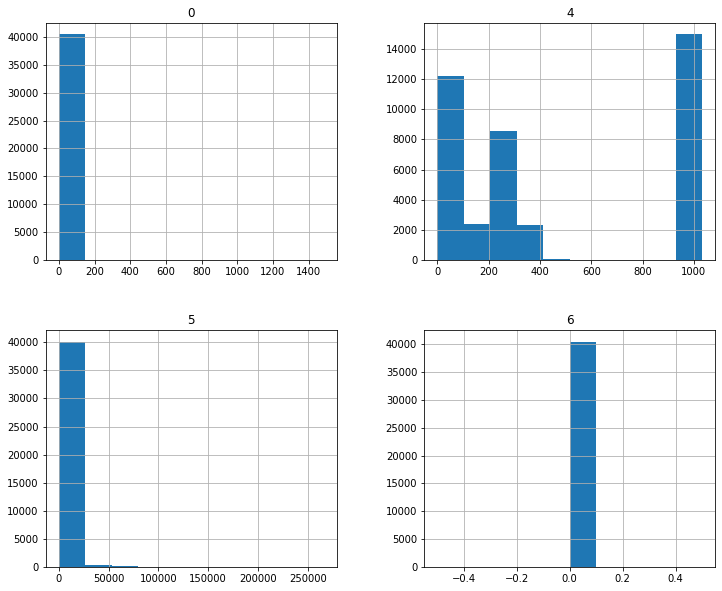

In [17]:
# Смотрим распределение значений в гистограммах для численных признаков.На 3 класса набирается только в 4 признаке 

df.hist(figsize=(12, 10))

In [18]:
df.drop(0, axis=1, inplace=True)
df.drop(5, axis=1, inplace=True)
df.drop(6, axis=1, inplace=True)

In [19]:
df

,1,2,3,4,41
0,icmp,ecr_i,SF,1032,smurf
1,icmp,ecr_i,SF,1032,smurf
2,icmp,ecr_i,SF,1032,smurf
3,icmp,ecr_i,SF,1032,smurf
4,icmp,ecr_i,SF,1032,smurf
...,...,...,...,...,...
40484,tcp,other,S0,0,satan
40485,tcp,other,S0,0,satan
40486,tcp,other,S0,0,satan
40487,tcp,other,S0,0,satan


In [20]:
df[4].value_counts()

1032    15000
0       11845
1         246
216       240
213       183
        ...  
6           1
140         1
387         1
383         1
511         1
Name: 4, Length: 258, dtype: int64

In [21]:
#  ПРоводим факторизацию численного признака - оставляем 3 класса

def f(x):
    if x == 1032:
        return 0
    if x == 0:
        return 1
    return 2

df[4].apply(f).value_counts()

0    15000
2    13644
1    11845
Name: 4, dtype: int64

In [22]:
df[4] = df[4].apply(f)
df

,1,2,3,4,41
0,icmp,ecr_i,SF,0,smurf
1,icmp,ecr_i,SF,0,smurf
2,icmp,ecr_i,SF,0,smurf
3,icmp,ecr_i,SF,0,smurf
4,icmp,ecr_i,SF,0,smurf
...,...,...,...,...,...
40484,tcp,other,S0,1,satan
40485,tcp,other,S0,1,satan
40486,tcp,other,S0,1,satan
40487,tcp,other,S0,1,satan


In [23]:
# Это пока не пригодилось

from sklearn.base import BaseEstimator, TransformerMixin


class DFSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attributes_names):
        self.attributes_names = attributes_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attributes_names]

In [24]:
# Это тоже пока не пригодилось

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OneHotEncoder, MinMaxScaler

class CustomLabelBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self, sparse_output=False):
        self.sparse_output = sparse_output
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        enc = LabelBinarizer(sparse_output=self.sparse_output)
        return enc.fit_transform(X)
    
num_attrs = [0, 4, 5]
cat_attrs = [1, 2, 3, 4]

num_features_pipeline = Pipeline([
    ('DataFrame2Numpy', DFSelector(attributes_names=num_attrs)),
    ('Normalizer', MinMaxScaler())
])

cat_features_pipeline = Pipeline([
    ('DataFrame2Numpy', DFSelector(attributes_names=cat_attrs)),
    ('CategoricalEncoder', LabelBinarizer())
])

In [25]:
# Как и это

def data_preprocessing(data):
    #data.iloc[:, num_attrs] = num_features_pipeline.fit_transform(data)
    for i in cat_attrs:
        data[i], _ = data[i].factorize()
        encoder = OneHotEncoder(categories='auto', sparse=False)
        data[i] = encoder.fit_transform(data[i].values.reshape(-1, 1)).todense()
    data[41], _ = data[41].factorize()
    return data

In [26]:
# Оставили только 4 признака

for i in (1, 2, 3, 4):
    print(df[i].value_counts())

tcp     25121
icmp    15107
udp       261
Name: 1, dtype: int64
ecr_i    15107
http     13286
other    12096
Name: 2, dtype: int64
SF     28650
REJ    10323
S0      1516
Name: 3, dtype: int64
0    15000
2    13644
1    11845
Name: 4, dtype: int64


In [27]:
# Этот класс вместо того, чтобы делать стратифицированные выборки, просто выкидывал третий класс из 3 признака

#from sklearn.model_selection import StratifiedShuffleSplit

#split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

#for train_index, test_index in split.split(df, df[41]):
#    test_df = df.loc[test_index]
#    df = df.loc[train_index]
    
#for train_index, val_index in split.split(df, df[41]):
#    val_df = df.loc[val_index]
#    df = df.loc[train_index]


# Выделяем тестовый, обучающий и валидационный наборы данных

num = int(len(df) / 10)

df = df.sample(frac=1)
test_df = df[:num]
val_df = df[num:num * 2]
df = df[num * 2:]

In [28]:
for i in (1, 2, 3, 4):
    print(test_df[i].value_counts())

tcp     2511
icmp    1514
udp       23
Name: 1, dtype: int64
ecr_i    1514
http     1346
other    1188
Name: 2, dtype: int64
SF     2883
REJ    1006
S0      159
Name: 3, dtype: int64
0    1507
2    1376
1    1165
Name: 4, dtype: int64


In [29]:
df

,1,2,3,4,41
8002,icmp,ecr_i,SF,0,smurf
24595,tcp,http,SF,2,normal
35890,tcp,other,REJ,1,satan
25073,tcp,http,SF,2,normal
39067,tcp,other,S0,1,satan
...,...,...,...,...,...
5525,icmp,ecr_i,SF,0,smurf
34340,tcp,other,REJ,1,satan
39044,tcp,other,S0,1,satan
8977,icmp,ecr_i,SF,0,smurf


In [35]:
# Функция для преобразования значений категориального признака в one-hot vectors 

tf.one_hot(a, depth=3)

<tf.Tensor: id=4, shape=(32391, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)>

In [38]:
# Так как конвееры обработки данных пока не работают корректно, ручками профодим факторизацию признаков без кодирования в вектора
#df = data_preprocessing(df)

for i in cat_attrs:
    df[i], _ = df[i].factorize()
    #df[i] = tf.convert_to_tensor(tf.one_hot(df[i], depth=3))
df[41], _ = df[41].factorize()

#target = tf.convert_to_tensor(df.pop(41))
target = df.pop(41)
dataset = tf.data.Dataset.from_tensor_slices((df.values, target.values))


for i in cat_attrs:
    val_df[i], _ = val_df[i].factorize()
    #val_df[i] = tf.convert_to_tensor(tf.one_hot(val_df[i], depth=3))
val_df[41], _ = val_df[41].factorize()

#val_df = data_preprocessing(val_df)
#val_target = tf.convert_to_tensor(val_df.pop(41))
val_target = val_df.pop(41)
val_dataset = tf.data.Dataset.from_tensor_slices((val_df.values, val_target.values))


for i in cat_attrs:
    test_df[i], _ = test_df[i].factorize()
    #test_df[i] = tf.convert_to_tensor(tf.one_hot(test_df[i], depth=3))
test_df[41], _ = test_df[41].factorize()

#test_df = data_preprocessing(test_df)
#test_target = tf.convert_to_tensor(test_df.pop(41))
test_target = test_df.pop(41)
test_dataset = tf.data.Dataset.from_tensor_slices((test_df.values, test_target.values))

In [39]:
BATCH_SIZE = 64

train_dataset = dataset.shuffle(len(df)).batch(BATCH_SIZE)
val_dataset = val_dataset.shuffle(len(val_df)).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_df)).batch(BATCH_SIZE)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f73f7e09290>,
      dtype=object)

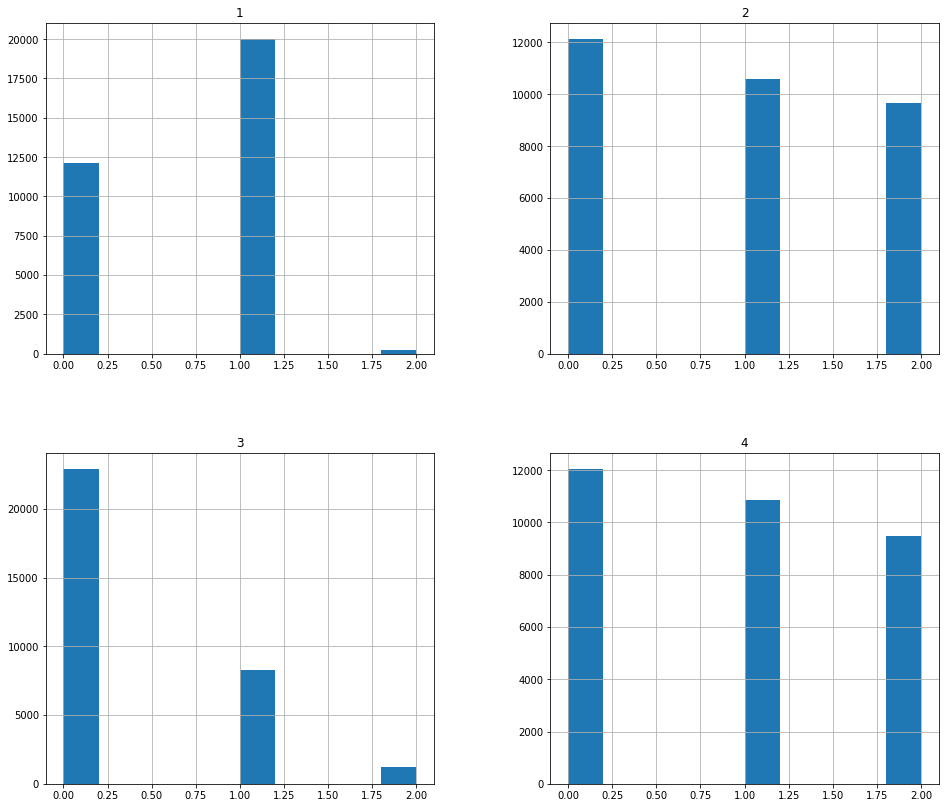

In [168]:
# Не смотря на 1 и 3 признак, распределение по классом достаточно равномерное

df.hist(figsize=(16, 14))

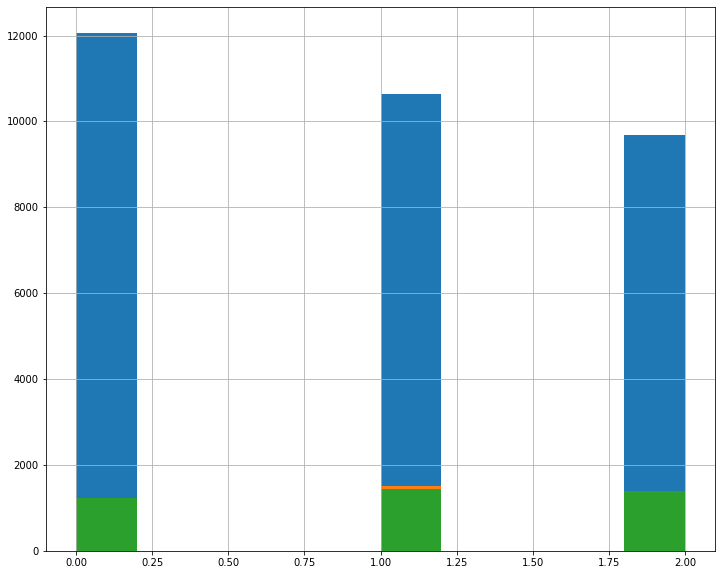

In [143]:
# Распределение классов тоже достаточно адекватное на всех 3 множествах

target.hist(figsize=(12, 10))
test_target.hist(figsize=(12, 10))
val_target.hist(figsize=(12, 10))

In [166]:
def get_compiled_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(18, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(9, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [167]:
model = get_compiled_model()
epochs = 30
history = model.fit(train_dataset, validation_data=val_dataset, use_multiprocessing=True, epochs=epochs)

Epoch 1/30
507/507 [==============================] - 1s 3ms/step - loss: 0.3263 - accuracy: 0.9103 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/30
507/507 [==============================] - 1s 1ms/step - loss: 0.1451 - accuracy: 0.9572 - val_loss: 3.0147 - val_accuracy: 0.6033
Epoch 3/30
507/507 [==============================] - 1s 1ms/step - loss: 0.1162 - accuracy: 0.9667 - val_loss: 3.4603 - val_accuracy: 0.6033
Epoch 4/30
507/507 [==============================] - 1s 1ms/step - loss: 0.1082 - accuracy: 0.9677 - val_loss: 4.0936 - val_accuracy: 0.6033
Epoch 5/30
507/507 [==============================] - 1s 1ms/step - loss: 0.1062 - accuracy: 0.9675 - val_loss: 4.2484 - val_accuracy: 0.6033
Epoch 6/30
507/507 [==============================] - 1s 1ms/step - loss: 0.0990 - accuracy: 0.9695 - val_loss: 4.6816 - val_accuracy: 0.6033
Epoch 7/30
507/507 [==============================] - 1s 1ms/step - loss: 0.0976 - accuracy: 0.9695 - val_loss: 4.1539 - val_accuracy: 0.603

KeyboardInterrupt: 

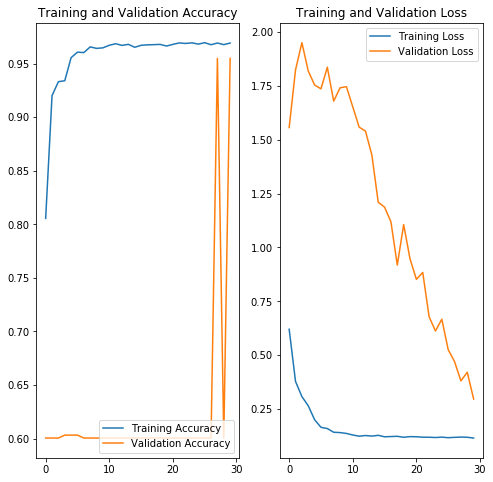

In [162]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [164]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print('Accuracy on test dataset:', test_accuracy)

64/64 [==============================] - 0s 874us/step - loss: 0.6509 - accuracy: 0.7441
Accuracy on test dataset: 0.7440711


In [165]:
model.summary()

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_147 (Dense)            multiple                  45        
_________________________________________________________________
dropout_47 (Dropout)         multiple                  0         
_________________________________________________________________
batch_normalization_19 (Batc multiple                  36        
_________________________________________________________________
dense_148 (Dense)            multiple                  50        
_________________________________________________________________
dense_149 (Dense)            multiple                  18        
Total params: 149
Trainable params: 131
Non-trainable params: 18
_________________________________________________________________
